Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
###

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 16

In [3]:
dataset_path = 'Yoga_Dataset'

In [4]:
# split into train and test
training_set = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.2,  # 80% train, 20% test
    subset="training"
)


Found 10668 files belonging to 8 classes.
Using 8535 files for training.


In [5]:
test_set = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 10668 files belonging to 8 classes.
Using 2133 files for validation.


In [6]:
# Get class names (pose names)
class_names = training_set.class_names
print("Classes:", class_names)

Classes: ['Adho Mukha Svanasana', 'Anjaneyasana', 'Phalakasana', 'Setu Bandha Sarvangasana', 'Trikonasana', 'Utkatasana', 'Virabhadrasana Two', 'Vrksasana']


In [7]:
# Normalization layer
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0 / 255)
])

In [8]:
# Define augmentation and normalization
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    #RandomRotation(0.2)
])

In [9]:
# Apply augmentation to training set, then normalize
training_set = training_set.map(lambda x, y: (resize_and_rescale(data_augmentation(x)), y))

In [10]:
# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)

In [11]:
#  Only normalize the test set (no augmentation)
test_set = test_set.map(lambda x, y: (resize_and_rescale(x), y))


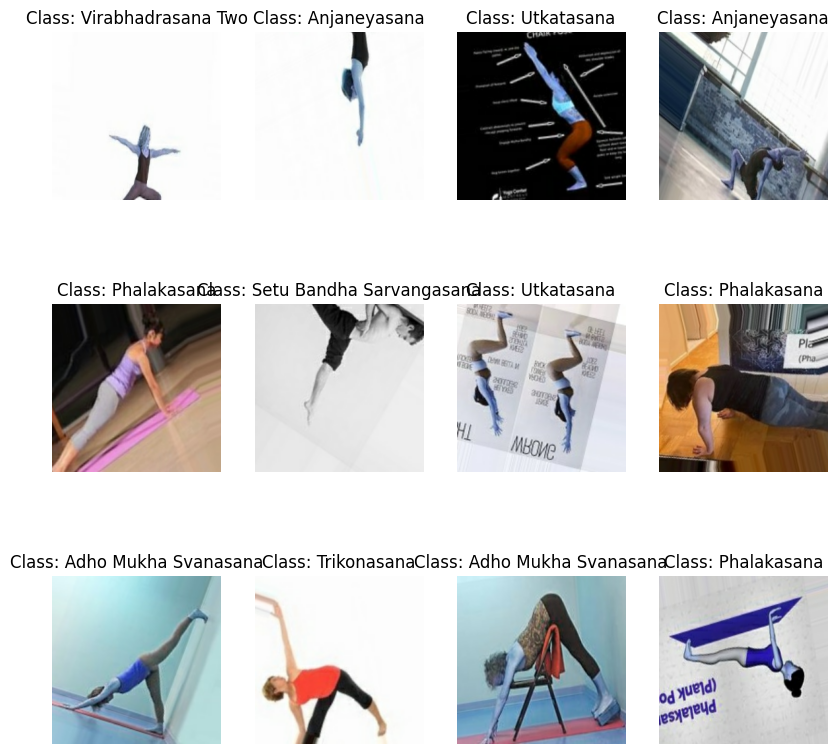

In [16]:
# Plotting a batch of augmented training images
plt.figure(figsize=(10, 10))
for image_batch, label_batch in training_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        img = image_batch[i].numpy() * 255  # Convert back to [0, 255] range
        img = img.astype("uint8")
        plt.imshow(img)
        plt.title("Class: " + class_names[label_batch[i].numpy()])
        plt.axis("off")
plt.show()

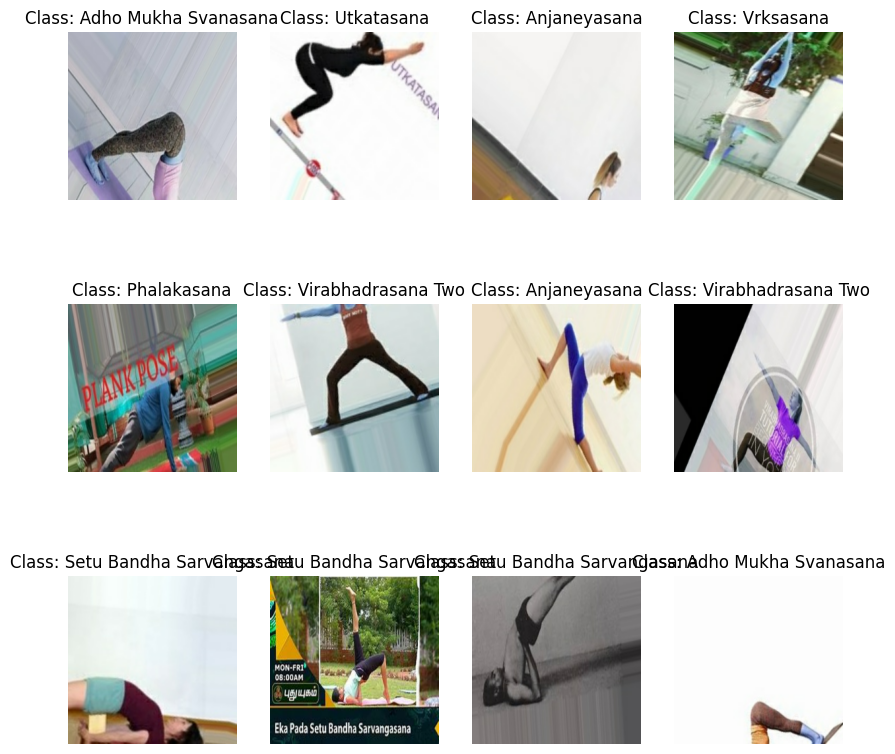

In [17]:
# Plotting a batch of test images (without augmentation)
plt.figure(figsize=(10, 10))
for image_batch, label_batch in test_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        img = image_batch[i].numpy() * 255
        img = img.astype("uint8")
        plt.imshow(img)
        plt.title("Class: " + class_names[label_batch[i].numpy()])
        plt.axis("off")
plt.show()

In [18]:
### END Preprocessing

## Model Implimentation

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [20]:
# Define the CNN model
def create_yoga_pose_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=8):
    model = Sequential()
    
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())  # Normalizing activations for better stability
    model.add(Dropout(0.25))
    
    # Second convolutional layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Third convolutional layer
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Fourth convolutional layer
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Flattening the layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [21]:
# Create the model
model = create_yoga_pose_model()

c:\Users\Buddhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [23]:

# Display model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         8,20

 Total params: 7,146,920 (27.26 MB)

 Trainable params: 7,145,960 (27.26 MB)

 Non-trainable params: 960 (3.75 KB)

In [24]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [18]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: False
Number of GPUs: 0
GPU Name: No GPU detected


In [25]:
# Set the number of epochs
EPOCHS = 20  

# Train the model
history = model.fit(training_set, validation_data=test_set, epochs=EPOCHS)

Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 120s 203ms/step - accuracy: 0.1369 - loss: 7.7591 - val_accuracy: 0.1857 - val_loss: 2.2248
Epoch 2/20
  2/534 ━━━━━━━━━━━━━━━━━━━━ 1:45 199ms/step - accuracy: 0.2656 - loss: 2.2227

KeyboardInterrupt: 

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

In [ ]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

In [ ]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()